- Name: Mahmood Reza Yassin
- Email: mahmoodr@ualberta.ca
- Phone: (+1) 587-357-4042

## Import Python libraries

In [1]:
import pandas as pd

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve

import seaborn as sn

import PIL.Image as Image

## General structure of training spreadsheet

In [2]:
df_raw = pd.read_excel('Training.xlsx')
df_raw.head()

,id,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category
0,7950115,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,2784,9
1,50950115,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,1328,9
2,119870115,Transformers 3,Transformers: Dark of the Moon,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,for intense prolonged sequences of sci-fi acti...,PG-13,Wide,1124,9
3,119590115,Toy Story 3,Toy Story 3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,General,G,Wide,1064,9
4,91700115,Pirates of the Caribbean 4,Pirates of the Caribbean: On Stranger Tides,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,for intense sequences of action/adventure viol...,PG-13,Wide,1044,9


There are 1196 attributes from 15 different fearures.

In [3]:
df_raw.shape

(1196, 15)

There is not any null or N/A data in the training dataset.

In [4]:
df_raw.isnull().sum()

id                                    0
name                                  0
display_name                          0
production_year                       0
movie_sequel                          0
creative_type                         0
source                                0
production_method                     0
genre                                 0
language                              0
board_rating_reason                   0
movie_board_rating_display_name       0
movie_release_pattern_display_name    0
total                                 0
Category                              0
dtype: int64

In [5]:
df_raw.isna().sum()

id                                    0
name                                  0
display_name                          0
production_year                       0
movie_sequel                          0
creative_type                         0
source                                0
production_method                     0
genre                                 0
language                              0
board_rating_reason                   0
movie_board_rating_display_name       0
movie_release_pattern_display_name    0
total                                 0
Category                              0
dtype: int64

There are 9 different categories based on total revenue. However, there are some inconsistency in the dataset. For instance, for total revenue = 5, we have Category 1 and 2 for many attributes:

In [6]:
df_raw[['total', 'Category']][1005:1030]

,total,Category
1005,6,2
1006,6,2
1007,6,2
1008,6,2
1009,6,2
1010,6,2
1011,5,1
1012,5,1
1013,5,2
1014,5,2


To solve this issue, we redefine the threshold boundary of different categories and correct the dataset as follows:

-        Total > 750    ===>>   Category = 9 
- 450 < Total <= 750   ===>>   Category = 8
- 275 < Total <= 450   ===>>   Category = 7
- 175 < Total <= 275   ===>>   Category = 6
- 100 < Total <= 175   ===>>   Category = 5
- 50  < Total <= 100   ===>>   Category = 4
- 20  < Total <= 50    ===>>   Category = 3
- 5   < Total <= 20    ===>>   Category = 2
- 0   < Total <= 5     ===>>   Category = 1

In [3]:
df = df_raw.copy(deep = True)

for ii in range(len(df['total'])):
    if df['total'][ii] > 750:
        df.loc[ii, 'Category'] = 9
    elif df['total'][ii] > 450 and df['total'][ii] <= 750:
        df.loc[ii, 'Category'] = 8
    elif df['total'][ii] > 275 and df['total'][ii] <= 450:
        df.loc[ii, 'Category'] = 7
    elif df['total'][ii] > 175 and df['total'][ii] <= 275:
        df.loc[ii, 'Category'] = 6
    elif df['total'][ii] > 100 and df['total'][ii] <= 175:
        df.loc[ii, 'Category'] = 5
    elif df['total'][ii] > 50 and df['total'][ii] <= 100:
        df.loc[ii, 'Category'] = 4
    elif df['total'][ii] > 20 and df['total'][ii] <= 50:
        df.loc[ii, 'Category'] = 3
    elif df['total'][ii] > 5 and df['total'][ii] <= 20:
        df.loc[ii, 'Category'] = 2
    elif df['total'][ii] > 0 and df['total'][ii] <= 5:
        df.loc[ii, 'Category'] = 1


We had 168 attributes with Category 1 in the original dataset. After correction of data, we have 185 attributes with Category 1.

In [8]:
print('Number of attributes with Category 1 in the original data=', sum(df_raw['Category'] == 1))
print('Number of attributes with Category 1 in the corrected data=', sum(df['Category'] == 1))

Number of attributes with Category 1 in the original data= 168
Number of attributes with Category 1 in the corrected data= 185


We had 247 attributes with Category 2 in the original dataset. After correction of data, we have 235 attributes with Category 2.

In [9]:
print('Number of attributes with Category 2 in the original data=', sum(df_raw['Category'] == 2))
print('Number of attributes with Category 2 in the corrected data=', sum(df['Category'] == 2))

Number of attributes with Category 2 in the original data= 247
Number of attributes with Category 2 in the corrected data= 235


## Exploratory data  analysis

In this subsection, we investigate the effect of each feature on the category of each class. "id", "name", and "display_name" may not affect the total revenue. However, other categorical features may be considered as key features that influence the total revenue. It is important to mention that the movies with higher total revenue are categorized with higher numbers as we move from 1 to 9 with the increase in total revenue.

In [10]:
df.dtypes

id                                     int64
name                                  object
display_name                          object
production_year                        int64
movie_sequel                           int64
creative_type                         object
source                                object
production_method                     object
genre                                 object
language                              object
board_rating_reason                   object
movie_board_rating_display_name       object
movie_release_pattern_display_name    object
total                                  int64
Category                               int64
dtype: object

### movie_sequel
The movie_sequel feature can be 0 (No) or 1 (Yes). Based on the following box plot, the movies with movie_sequel = 1 result in a typically higher revenue, suggesting that the movies that continue an earlier work have a higher chance to be profitable. There are 1079 and 117 movies without and with the movie_sequel, respectively.

Number of unique movie_sequel = 2 

movie_sequel No = 1079 movies
movie_sequel Yes = 117 movies


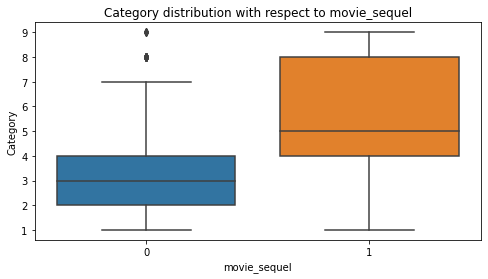

In [11]:
print('Number of unique movie_sequel =', len(df['movie_sequel'].unique()), '\n')
plt.figure(figsize=(8,4))
plt.title('Category distribution with respect to movie_sequel')
box = sn.boxplot(x = df['movie_sequel'],y = df['Category'])

print ('movie_sequel No =', sum(df['movie_sequel'] == 0), 'movies')
print ('movie_sequel Yes =', sum(df['movie_sequel'] == 1), 'movies')

### creative_type feature 
There are 9 different sub-categories in the creative_type feature. Based on the box plot, "Super Hero" and "Kids Fiction" movies typically have higher revenue while "Fractal" and "Multiple Creative Types" have lower profit. It should be mentioned that "Contemporray Fiction" and Fantasy have the highest frequency among creative_type sub-categories.

Number of unique creative_type= 9 

Fantasy = 131 movies
Kids Fiction = 59 movies
Contemporary Fiction = 638 movies


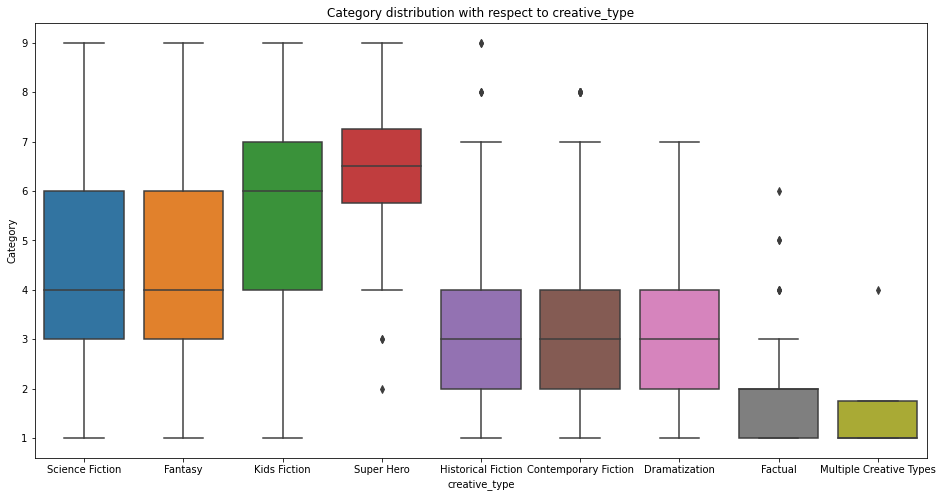

In [12]:
print('Number of unique creative_type=', len(df['creative_type'].unique()), '\n')
plt.figure(figsize=(16,8))
plt.title('Category distribution with respect to creative_type')
box = sn.boxplot(x = df['creative_type'],y = df['Category'])

print ('Fantasy =', sum(df['creative_type'] == 'Fantasy'), 'movies')
print ('Kids Fiction =', sum(df['creative_type'] == 'Kids Fiction'), 'movies')
print ('Contemporary Fiction =', sum(df['creative_type'] == 'Contemporary Fiction'), 'movies')

### source
There are 16 different sub-categories in the source feature. Based on the following box plot, "Cased on TV" and "Based on Comic/Graphic Novel" result in higher profit compared on "Based on Real Life Events". It should be mentioned that there are not many attributes for "Compilation" and "Based on Theme Park Ride" sub-categories.

Number of unique source= 16


[Text(0, 0, 'Original Screenplay'),
 Text(1, 0, 'Based on Fiction Book/Short Story'),
 Text(2, 0, 'Based on TV'),
 Text(3, 0, 'Based on Theme Park Ride'),
 Text(4, 0, 'Based on Comic/Graphic Novel'),
 Text(5, 0, 'Based on Factual Book/Article'),
 Text(6, 0, 'Based on Musical or Opera'),
 Text(7, 0, 'Based on Folk Tale/Legend/Fairytale'),
 Text(8, 0, 'Spin-Off'),
 Text(9, 0, 'Remake'),
 Text(10, 0, 'Based on Game'),
 Text(11, 0, 'Based on Toy'),
 Text(12, 0, 'Based on Real Life Events'),
 Text(13, 0, 'Based on Short Film'),
 Text(14, 0, 'Based on Play'),
 Text(15, 0, 'Compilation')]

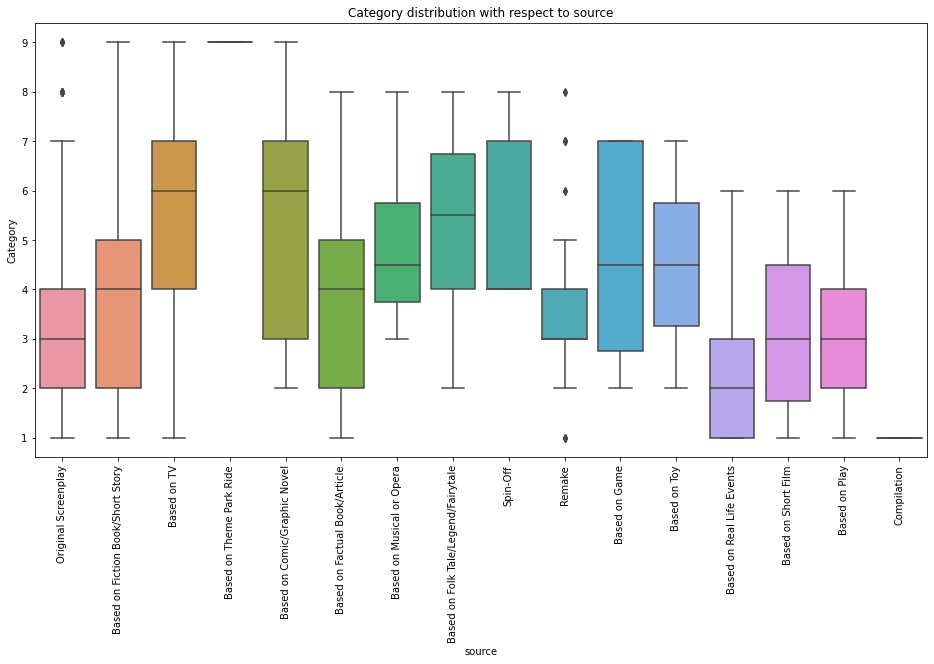

In [13]:
print('Number of unique source=', len(df['source'].unique()))
plt.figure(figsize=(16,8))
plt.title('Category distribution with respect to source')
box = sn.boxplot(x = df['source'],y = df['Category'])
labels = df['source'].unique()
box.set_xticklabels(labels, rotation = 90)

### production_method
Among 6 sub-categories shown below, "Animation/Live action" and "Digital Animation" movies typically result in a higher revenue compared to "Live Action" movies. There are not many attributes in the "Multiple Production Method".

Number of unique production_method= 6


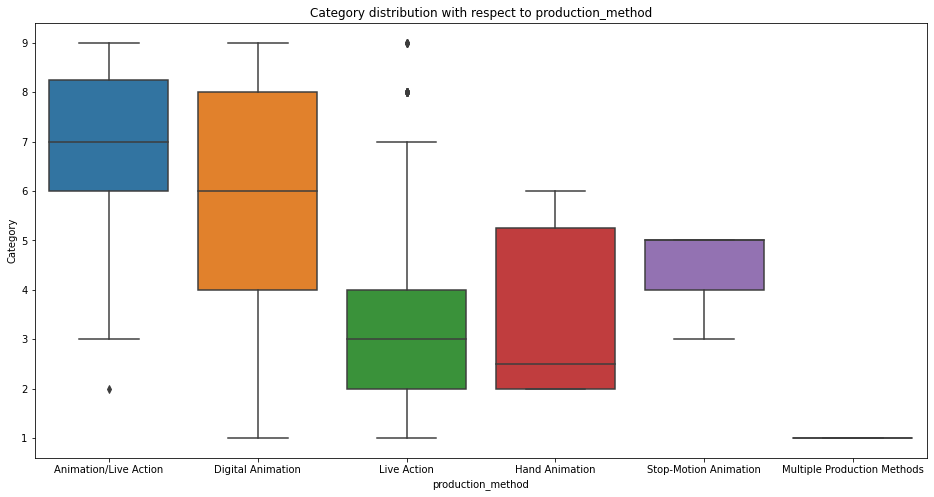

In [14]:
print('Number of unique production_method=', len(df['production_method'].unique()))
plt.figure(figsize=(16,8))
plt.title('Category distribution with respect to production_method')
box = sn.boxplot(x = df['production_method'],y = df['Category'])

### genre
There are 13 genere in total in which "Adventure", "Action", and "Musical" typically result in higher total revenue compared to "Documentary" genre. We do not have many attributes in the "Multiple Genres".

Number of unique genre= 13


[Text(0, 0, 'Action'),
 Text(1, 0, 'Adventure'),
 Text(2, 0, 'Thriller/Suspense'),
 Text(3, 0, 'Drama'),
 Text(4, 0, 'Comedy'),
 Text(5, 0, 'Musical'),
 Text(6, 0, 'Horror'),
 Text(7, 0, 'Romantic Comedy'),
 Text(8, 0, 'Western'),
 Text(9, 0, 'Documentary'),
 Text(10, 0, 'Black Comedy'),
 Text(11, 0, 'Concert/Performance'),
 Text(12, 0, 'Multiple Genres')]

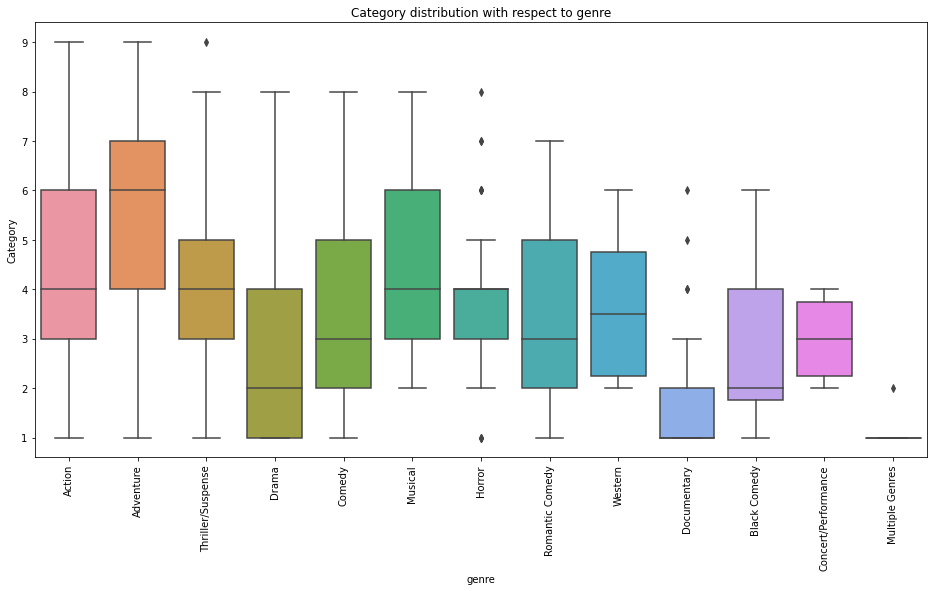

In [15]:
print('Number of unique genre=', len(df['genre'].unique()))
plt.figure(figsize=(16,8))
plt.title('Category distribution with respect to genre')
box = sn.boxplot(x = df['genre'],y = df['Category'])
labels = df['genre'].unique()
box.set_xticklabels(labels, rotation = 90)

### language
There are 16 different languages where 1144 out of 1196 (95%) of movies are in English. It seems like Japanese and Swedish movies are more profitable compared to English movies; however, it should be considred that the number of these movies in the training spreadsheet is insignificant compared to the number of English movies. There are only 2 Japanese and 2 Swedish movies in the training dataset.

Number of unique language= 16 

English = 1144 movies
French = 14 movies
Hindi = 16 movies
Japanese = 2 movies
Swedish = 2 movies


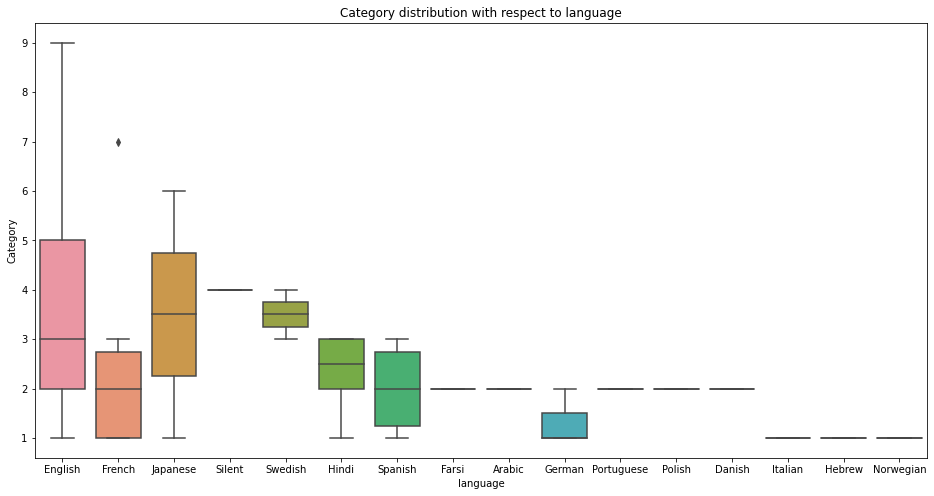

In [16]:
print('Number of unique language=', len(df['language'].unique()), '\n')
plt.figure(figsize=(16,8))
plt.title('Category distribution with respect to language')
box = sn.boxplot(x = df['language'],y = df['Category'])

print ('English =', sum(df['language'] == 'English'), 'movies')
print ('French =', sum(df['language'] == 'French'), 'movies')
print ('Hindi =', sum(df['language'] == 'Hindi'), 'movies')
print ('Japanese =', sum(df['language'] == 'Japanese'), 'movies')
print ('Swedish =', sum(df['language'] == 'Swedish'), 'movies')

The following bar chart shows "English" as the language with the highest frequency (95%) in the movie list.

<BarContainer object of 16 artists>

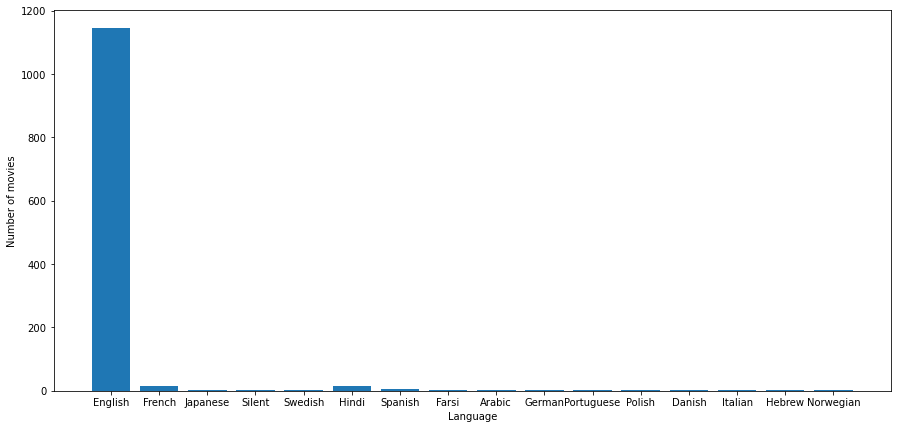

In [17]:
language_type = df['language'].unique()
language_count = []

for ii in range(len(language_type)):
    language_count.append (sum(df['language'] == language_type[ii])) 

plt.figure(figsize=(15,7))
ypos = np.arange(len(language_type))
plt.xticks(ypos, language_type)
plt.xlabel('Language')
plt.ylabel('Number of movies')
plt.bar(ypos, language_count)

### movie_board_rating_display_name 
There are 6 sub-category in the display_name. "PG-13" and "R" are the dominant rating_display with 441 and 448 movies, repectively. Based on the following box plot, it appears that display_rating does not strongly affect the total revenue, since the variation is not very significant!

Number of unique rating_display= 6 

PG-13 = 441 movies
R = 448 movies


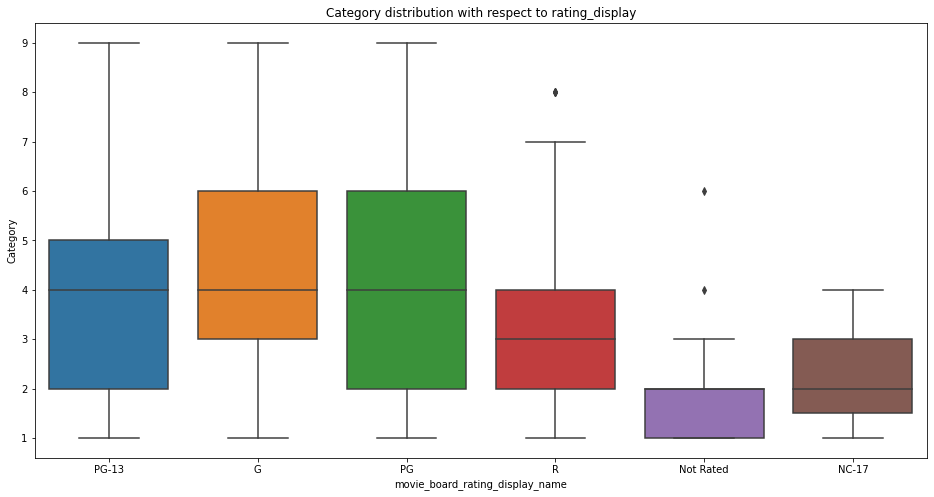

In [18]:
print('Number of unique rating_display=', len(df['movie_board_rating_display_name'].unique()), '\n')
plt.figure(figsize=(16,8))
plt.title('Category distribution with respect to rating_display')
box = sn.boxplot(x = df['movie_board_rating_display_name'],y = df['Category'])

print ('PG-13 =', sum(df['movie_board_rating_display_name'] == 'PG-13'), 'movies')
print ('R =', sum(df['movie_board_rating_display_name'] == 'R'), 'movies')

### movie_release_pattern_display_name
There are 7 sub-category in the pattern_display where "Wide" sub-category has the maximum abundance with 795 movies. 

Number of unique pattern_display= 7 

Wide = 795 movies


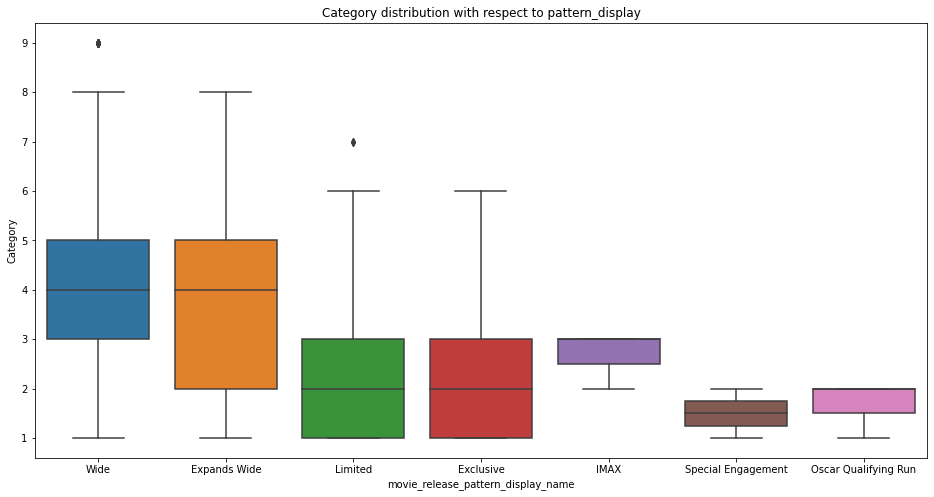

In [19]:
print('Number of unique pattern_display=', len(df['movie_release_pattern_display_name'].unique()), '\n')
plt.figure(figsize=(16,8))
plt.title('Category distribution with respect to pattern_display')
box = sn.boxplot(x = df['movie_release_pattern_display_name'],y = df['Category'])

print ('Wide =', sum(df['movie_release_pattern_display_name'] == 'Wide'), 'movies')

### Important Notes
- There is one feature named "board_rating_reason" that describes the reason behind "rating_display". In the first set of ML models, we do not analyze this feature because it consists of many words that should be analyzed by using other libraries and packages. In the first set of ML models, we try our best to evaluate the model as simple as possible.

- We ignore the effect of "production_year" in our ML models becuase the years in the training spreadsheet are in the range of 2007 to 2011. However, the years in the Scoring spreadsheet is 2012. The ML models may not work efficiently in the case of extrapolation and for this reason we do not consider "production_year" in our models. 

## Concatenate "Training" and "Scoring" Spreadsheets

In [4]:
train_1 = df.copy()
score_1 = pd.read_excel('Scoring.xlsx')

In [5]:
L = len(train_1)
L

1196

In [6]:
train_2 = train_1.drop(['id', 'name', 'display_name', 'production_year', 'board_rating_reason'], axis = 1)
train_2.shape

(1196, 10)

In [7]:
score_2 = score_1.drop(['id', 'name', 'display_name', 'production_budget', 'production_year', 'board_rating_reason'], axis = 1)
score_2.shape

(91, 10)

In [8]:
train_score = pd.concat(objs=[train_2, score_2], axis=0)
train_score.shape

(1287, 10)

## Regression or classification problem
We can approch the ML problem in two different ways.
- In the first approach which is a regression problem, our output is "Total" which is a continuous variable. After prediction of total revenue, we classify each movie in one of the aforementioned 9 categories.
- In the second approch which is a classification problem, we directly model the category of each movie without dealing with total revenue.

We drop the column of "Category" for regression problems and do the same with the column of "tota" for classification problems.
### (I) Regression
We drop unnecessary features including 'Category' for regression problem:

In [9]:
df_regression = train_score.drop(['Category'], axis = 1)
df_regression.shape

(1287, 9)

### (II) Classification
We drop unnecessary features including 'Total' for "claffification" problem:

In [10]:
df_classification = train_score.drop(['total'], axis = 1)
df_classification.shape

(1287, 9)

## Mapping categorical features

## 1. One Hot Encodding - mapping categorical columns to binary 0 or 1
In this subsection, we convert categorical variables to 0 or 1 by using One-Hot-Encoding technique:
### (I) Regression

In [11]:
df2_regression = pd.get_dummies(data = df_regression, columns = ['creative_type', 'source',\
'production_method', 'genre', 'language', 'movie_board_rating_display_name','movie_release_pattern_display_name'])

df2_regression.shape

(1287, 76)

### (II) Classification

In [12]:
df2_classification = pd.get_dummies(data = df_classification, columns = ['creative_type', 'source', \
'production_method', 'genre', 'language', 'movie_board_rating_display_name','movie_release_pattern_display_name'])

df2_classification.shape

(1287, 76)

In the original dataset, we had 8 input features. After One-Hot-Encoding we have 75 input features.

## 2. Factorization - mapping categorical columns to numeric values
The second method for mapping categorical columns is factorization. For instance, we have 13 genres and the factorization method converts each string into a number from 0 to 12.

In [13]:
# The input data of this function is df_regression or df_classification

def factorization(data, output_name, test_size):
    df1 = data.copy(deep = True)
    df2 = pd.DataFrame()
    
    df2['movie_sequel'] = df1['movie_sequel']
    df2['creative_type'] = pd.factorize(df1.creative_type)[0]
    df2['source'] = pd.factorize(df1.source)[0]
    df2['production_method'] = pd.factorize(df1.production_method)[0]
    df2['genre'] = pd.factorize(df1.genre)[0]
    df2['language'] = pd.factorize(df1.language)[0]
    df2['movie_board_rating_display_name'] = pd.factorize(df1.movie_board_rating_display_name)[0]
    df2['movie_release_pattern_display_name'] = pd.factorize(df1.movie_release_pattern_display_name)[0]
    df2[output_name] = df1[output_name]
        
    X_factorized = df2.drop(output_name, axis = 'columns')
    y = df2[output_name]
    
    L = 1196
    X_train_test = X_factorized[:L].copy()
    y_train_test = y[:L].copy()
    
    X_score = X_factorized[L:].copy()
    X_score = np.array(X_score)
    
    X_factorized = np.array(X_factorized)
    
    
    if output_name == 'total':
        y_train_test = np.log(np.array(y_train_test)) / np.log(2784)
    else:
        y_train_test = np.array(y_train_test)
        
     
    X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size = test_size, random_state = 20)
    
    return(X_train, X_test, y_train, y_test, X_score)
    

## Feature Selection 
## 1. Univariate Selection
In case we apply One-Hot-Encodding method, we will have 75 input features that may result in overfitting of the ML model. We should filter the input variables that have stronger correlation with the output variable. One technique is "Univariate Selection".

In [14]:
# The input data of this function is df2_regression or df2_classification

def Universal_Selection (df2, output_name, n_features, test_size):
    X = df2.drop(output_name, axis = 'columns')
    y = df2[output_name]
    
    L = 1196
    X_1 = X[:L].copy()
    y_1 = y[:L].copy()
    
    bestfeatures = SelectKBest(score_func=chi2, k=3)
    fit = bestfeatures.fit(X_1,y_1)
    
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    feature_Scores = pd.concat([dfcolumns,dfscores],axis=1)
    feature_Scores.columns = ['Specs','Score']
    
    Top_features = feature_Scores.nlargest(n_features,'Score')
    
    X_featured_US = pd.DataFrame()
    
    for ii in Top_features['Specs']:
        X_featured_US[ii] = X[ii]

    X_train_test = X_featured_US[:L].copy()
    X_train_test = np.array(X_train_test)
    
    X_score = X_featured_US[L:].copy()
    X_score = np.array(X_score)
    
    
    y_train_test = y_1.copy()
    if output_name == 'total':
        y_train_test = np.log(np.array(y_train_test)) / np.log(2784)
    else:
        y_train_test = np.array(y_train_test)
         
    
    X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size = test_size, random_state = 20)
    
    print(Top_features)
    
    return(X_train, X_test, y_train, y_test, X_score)


## 2. Feature Importance
The second technique for feature selection is "Feature Importance".

In [15]:
def Feature_Importance (df2, output_name, n_features, test_size):
    X = df2.drop(output_name, axis = 'columns')
    y = df2[output_name]
    
    L = 1196
    X_1 = X[:L].copy()
    y_1 = y[:L].copy()
    
    model_FI = ExtraTreesClassifier()
    model_FI.fit(X,y)
    
    feat_importances = pd.DataFrame(model_FI.feature_importances_, X_1.columns)
    
    output_FI = pd.DataFrame()
    output_FI ['importance'] = model_FI.feature_importances_
    output_FI ['feature'] = X_1.columns
    
    output_FI = output_FI.nlargest(n_features, columns = ['importance'], keep = 'first')
    #output_FI.plot.bar(x = 'feature', y = 'importance')
    
    X_featured_FI = pd.DataFrame()

    for ii in output_FI['feature']:
        X_featured_FI[ii] = X[ii]
    
    
    X_train_test = X_featured_FI[:L].copy()
    X_train_test = np.array(X_train_test)
    
    X_score = X_featured_FI[L:].copy()
    X_score = np.array(X_score)
    
    y_train_test = y_1.copy()
    if output_name == 'total':
        y_train_test = np.log(np.array(y_train_test)) / np.log(2784)
    else:
        y_train_test = np.array(y_train_test)
    
    X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size = test_size, random_state = 20)
    
    print(output_FI)
    
    return(X_train, X_test, y_train, y_test, X_score)

# Regression and Classification Models
In this section, we test the performance of different regression and classification models. We use the random_state = 20 to have the same set of training and test dataset for all ML models.

## 1. Logistic Regression
### (I) Feature Importance
For modeling the "Category" data by logistic regression, we need to perform feature selection. We choose different values of n_feature and finally come up with the one that lead to the highest accuracy of test_data prediction. We picked n_feature = 15 as the optimum value for the logistic regression.

In [32]:
X_train, X_test, y_train, y_test, X_score = \
Feature_Importance (df2_classification, 'Category', n_features = 15, test_size = 0.2)

    importance                                     feature
74    0.053083     movie_release_pattern_display_name_Wide
0     0.049097                                movie_sequel
23    0.044938                  source_Original Screenplay
12    0.042963    source_Based on Fiction Book/Short Story
71    0.042953  movie_release_pattern_display_name_Limited
66    0.037405       movie_board_rating_display_name_PG-13
67    0.036884           movie_board_rating_display_name_R
1     0.035693          creative_type_Contemporary Fiction
35    0.034010                                genre_Comedy
38    0.032156                                 genre_Drama
32    0.030268                                genre_Action
43    0.029251                     genre_Thriller/Suspense
4     0.028237                       creative_type_Fantasy
5     0.027575            creative_type_Historical Fiction
65    0.026977          movie_board_rating_display_name_PG


In [33]:
X_score.shape

(91, 15)

In [34]:
X_test.shape

(240, 15)

In [35]:
model_LR_FI = LogisticRegression(C = 1, max_iter = 200, multi_class = 'ovr', solver='lbfgs')
model_LR_FI.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=200, multi_class='ovr')

The accuracy of the model on test data is 0.27

In [37]:
model_LR_FI.score(X_test, y_test)

0.275

In [38]:
y_predicted = model_LR_FI.predict(X_test)

As you can see in the confusion matrix below, the logistic regression does not have a very high accuracy in prediction of categories larger than 6.

Text(69.0, 0.5, 'Truth')

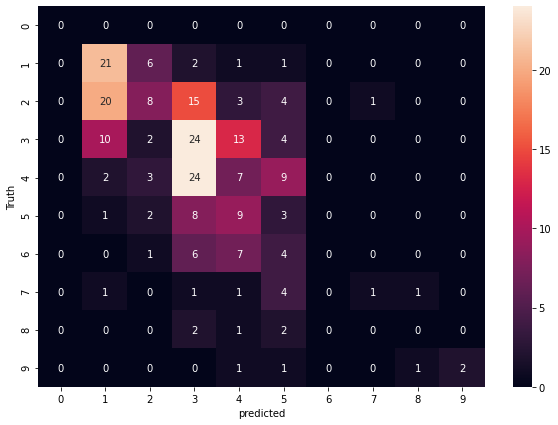

In [39]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

We use weighted average F1-score to compare the performance of different ML models. For logistic regression on 15 features, we could get F-score = 0.25. 

In [40]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           1       0.38      0.68      0.49        31
           2       0.36      0.16      0.22        51
           3       0.29      0.45      0.36        53
           4       0.16      0.16      0.16        45
           5       0.09      0.13      0.11        23
           6       0.00      0.00      0.00        18
           7       0.50      0.11      0.18         9
           8       0.00      0.00      0.00         5
           9       1.00      0.40      0.57         5

    accuracy                           0.28       240
   macro avg       0.31      0.23      0.23       240
weighted avg       0.27      0.28      0.25       240



The following line of code estimates the category of movies in the scoring dataset.

In [42]:
y_score_LR_FI = pd.DataFrame(model_LR_FI.predict(X_score))
y_score_LR_FI

,0
0,4
1,8
2,5
3,5
4,9
...,...
86,1
87,1
88,1
89,1


### (II) Universal Selection
Let's try the performance of the Universal_Selection for picking the first 15 features.

In [43]:
X_train, X_test, y_train, y_test, X_score = \
Universal_Selection (df2_classification, 'Category', n_features = 15, test_size = 0.2)

                                         Specs       Score
71  movie_release_pattern_display_name_Limited  256.906456
0                                 movie_sequel  193.406708
26     production_method_Animation/Live Action  189.266407
33                             genre_Adventure  157.820801
74     movie_release_pattern_display_name_Wide  133.005488
20             source_Based on Theme Park Ride  123.894737
27         production_method_Digital Animation  116.990852
64   movie_board_rating_display_name_Not Rated   93.446131
6                   creative_type_Kids Fiction   82.342770
37                           genre_Documentary   70.249386
17            source_Based on Real Life Events   58.059202
38                                 genre_Drama   57.911371
3                        creative_type_Factual   55.601025
9                     creative_type_Super Hero   51.934194
4                        creative_type_Fantasy   45.813701


In [44]:
X_score.shape

(91, 15)

In [45]:
X_test.shape

(240, 15)

In [46]:
model_LR_US = LogisticRegression(C = 1, max_iter = 200, multi_class = 'ovr', solver='lbfgs')
model_LR_US.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=200, multi_class='ovr')

The accuracy of the model on test data is 0.26 which is lower than the previous case with Feature_Importance (0.28).

In [47]:
model_LR_US.score(X_test, y_test)

0.26666666666666666

In [48]:
y_predicted = model_LR_US.predict(X_test)

Similarly, the logistic regression does not have a very high accuracy in prediction of categories larger than 6.

Text(69.0, 0.5, 'Truth')

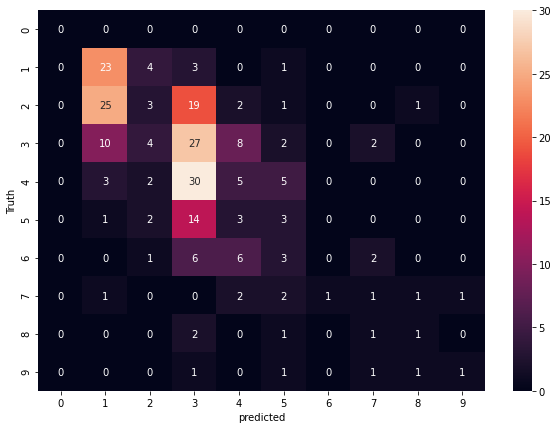

In [49]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F1-Score is 0.21 which is lowrer than 0.25 in the previous case.

In [50]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           1       0.37      0.74      0.49        31
           2       0.19      0.06      0.09        51
           3       0.26      0.51      0.35        53
           4       0.19      0.11      0.14        45
           5       0.16      0.13      0.14        23
           6       0.00      0.00      0.00        18
           7       0.14      0.11      0.12         9
           8       0.25      0.20      0.22         5
           9       0.50      0.20      0.29         5

    accuracy                           0.27       240
   macro avg       0.23      0.23      0.20       240
weighted avg       0.22      0.27      0.21       240



The following line of code estimates the category of movies in the scoring dataset.

In [51]:
y_score_LR_US = pd.DataFrame(model_LR_US.predict(X_score))
y_score_LR_US

,0
0,6
1,8
2,5
3,5
4,9
...,...
86,1
87,1
88,1
89,1


## 2. Random Forest Using One-Hot-Encoding
We use Feature_Importance and come up with n_feature = 20 as the optimum number of features.

In [92]:
X_train, X_test, y_train, y_test, X_score = \
Feature_Importance (df2_classification, 'Category', n_features = 20, test_size = 0.2)

    importance                                     feature
74    0.052866     movie_release_pattern_display_name_Wide
0     0.048338                                movie_sequel
23    0.046887                  source_Original Screenplay
71    0.043895  movie_release_pattern_display_name_Limited
12    0.043691    source_Based on Fiction Book/Short Story
66    0.041108       movie_board_rating_display_name_PG-13
67    0.039762           movie_board_rating_display_name_R
1     0.034824          creative_type_Contemporary Fiction
35    0.032061                                genre_Comedy
38    0.031052                                 genre_Drama
4     0.030325                       creative_type_Fantasy
65    0.029240          movie_board_rating_display_name_PG
32    0.028073                                genre_Action
43    0.027538                     genre_Thriller/Suspense
8     0.027318               creative_type_Science Fiction
5     0.026563            creative_type_Historical Ficti

In [53]:
X_score.shape

(91, 20)

In [54]:
X_test.shape

(240, 20)

There are two important prameters that should be optimized as the inputs of the Random Forest. We use GridSearchCV to find the optimum values of "max_depth" and "max_leaf_nodes" that result in the maximum accuracy. The GridSearchCV algorithm gives max_depth = 15 and max_leaf_nodes = 20.

In [55]:
param_grid = [
    {'max_depth' : [5, 10, 15, 20, 30],
     'max_leaf_nodes' : [20, 30, 40, 50, 60] 
    }
]

optimal_params = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, scoring = 'accuracy', verbose = 0)

optimal_params.fit(X_train, y_train)

print(optimal_params.best_params_)

{'max_depth': 20, 'max_leaf_nodes': 30}


However, max_depth = 7 and max_leaf_nodes = 50 give higher accuracy! This discreapancy might be due to data mismatch between training and test datasets!

In [95]:
model_RF_hot = RandomForestClassifier(max_depth = 7, max_leaf_nodes = 50, n_estimators = 300)
model_RF_hot.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_leaf_nodes=50, n_estimators=300)

Model accuracy is on test data in around 0.31 which is considerably higher than the accuracy of logistic regression models.

In [96]:
model_RF_hot.score(X_test, y_test)

0.3125

In [97]:
y_predicted = model_RF_hot.predict(X_test)

As shown in the confusion matrix below, Random Forest has a better accuracy in predicting the label of categories higher than 6 compared to logistic regression models.

Text(69.0, 0.5, 'Truth')

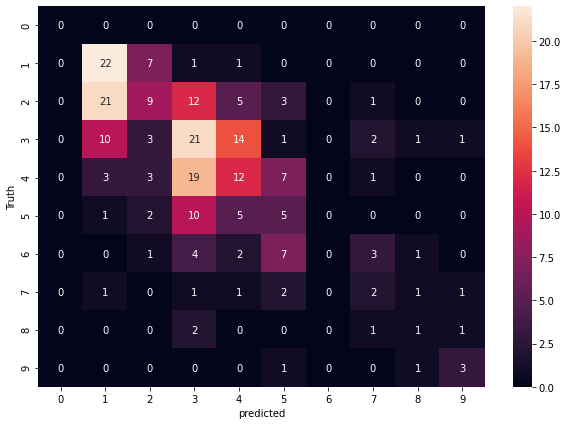

In [98]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

And finally F-Score = 0.29 which is relatively better than F-Score of logistic regression models.

In [100]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           1       0.38      0.71      0.49        31
           2       0.36      0.18      0.24        51
           3       0.30      0.40      0.34        53
           4       0.30      0.27      0.28        45
           5       0.19      0.22      0.20        23
           6       0.00      0.00      0.00        18
           7       0.20      0.22      0.21         9
           8       0.20      0.20      0.20         5
           9       0.50      0.60      0.55         5

    accuracy                           0.31       240
   macro avg       0.27      0.31      0.28       240
weighted avg       0.29      0.31      0.29       240



The following line of code estimates the category of movies in the scoring dataset.

In [101]:
y_score_RF_hot = pd.DataFrame(model_RF_hot.predict(X_score))
y_score_RF_hot

,0
0,5
1,8
2,8
3,8
4,9
...,...
86,1
87,1
88,1
89,1


## 3. Random Forest Using Factorization of Input Data
In this subsection, we use factorization to handle categorical input variables. As shown below, we have 8 input variables and we use all of them for training the Random Forest model.

In [65]:
X_train, X_test, y_train, y_test, X_score = factorization(df_classification, 'Category', test_size = 0.2)

In [66]:
X_score.shape

(91, 8)

In [67]:
X_test.shape

(240, 8)

We use GridSearchCV to find optimized values of "max_depth" and "max_leaf_nodes".

In [68]:
param_grid = [
    {'max_depth' : [5, 10, 15, 20, 30],
     'max_leaf_nodes' : [20, 30, 40, 50, 60, 70, 80] 
    }
]

optimal_params = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, scoring = 'accuracy', verbose = 0)

optimal_params.fit(X_train, y_train)

print(optimal_params.best_params_)

{'max_depth': 5, 'max_leaf_nodes': 40}


Despite above values, we use max_depth = 15 and max_leaf_nodes = 100 that result in higher accuracy of the test data. This discreapancy might be due to data mismatch between training and test datasets!

In [81]:
model_RF_cat = RandomForestClassifier(max_depth = 15, max_leaf_nodes = 100, n_estimators=50)
model_RF_cat.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_leaf_nodes=100, n_estimators=50)

The model accuracy on test data is 0.33 which is close to the accuracy of the previous Ransom Forest model.

In [82]:
model_RF_cat.score(X_test, y_test)

0.3333333333333333

In [83]:
y_predicted = model_RF_cat.predict(X_test)

As shown in the confusion matrix below, Random Forest has a relatively better accuracy in predicting the label of categories higher than 6 compared to logistic regression models.

Text(69.0, 0.5, 'Truth')

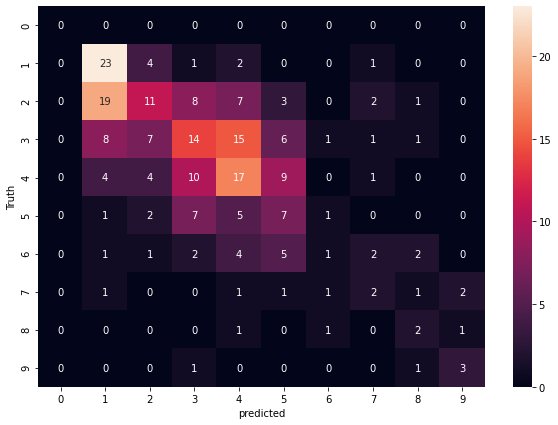

In [84]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

As listed below, F-Score = 0.31 which is the highest value among all the model F-scores that we investigated so far!

In [85]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           1       0.40      0.74      0.52        31
           2       0.38      0.22      0.28        51
           3       0.33      0.26      0.29        53
           4       0.33      0.38      0.35        45
           5       0.23      0.30      0.26        23
           6       0.20      0.06      0.09        18
           7       0.22      0.22      0.22         9
           8       0.25      0.40      0.31         5
           9       0.50      0.60      0.55         5

    accuracy                           0.33       240
   macro avg       0.31      0.35      0.32       240
weighted avg       0.33      0.33      0.31       240



The following line of code estimates the category of movies in the scoring dataset.

In [86]:
y_score_RF_cat = pd.DataFrame(model_RF_cat.predict(X_score))
y_score_RF_cat

,0
0,6
1,9
2,8
3,8
4,9
...,...
86,1
87,2
88,1
89,1


## 4. Support Vector Machine (SVM)
In this subsection, we use SVM for multi-class classification.

In [109]:
X_train, X_test, y_train, y_test, X_score = \
Feature_Importance (df2_classification, 'Category', n_features = 15, test_size = 0.2)

    importance                                     feature
74    0.052922     movie_release_pattern_display_name_Wide
0     0.049889                                movie_sequel
23    0.044048                  source_Original Screenplay
71    0.043960  movie_release_pattern_display_name_Limited
12    0.043653    source_Based on Fiction Book/Short Story
67    0.037263           movie_board_rating_display_name_R
66    0.037166       movie_board_rating_display_name_PG-13
1     0.036068          creative_type_Contemporary Fiction
35    0.034540                                genre_Comedy
38    0.032541                                 genre_Drama
32    0.029552                                genre_Action
43    0.029069                     genre_Thriller/Suspense
4     0.028892                       creative_type_Fantasy
8     0.027362               creative_type_Science Fiction
65    0.026892          movie_board_rating_display_name_PG


In [110]:
X_score.shape

(91, 15)

In [111]:
X_test.shape

(240, 15)

We use "RBF" as the kernel function for SVM. However, for "C" and "gamma" hyperparameters, we use GridSearchCV that eventually gives C = 100 and gamma = 0.001 as the optimum hyperparameters.

In [112]:
param_grid = [
    {'C' : [0.5, 1, 10, 100],
     'gamma' : ['scale', 1, 0.1, 0.001, 0.0001], 
     'kernel' : ['rbf']   
    }
]

optimal_params = GridSearchCV(SVC(), param_grid, cv = 5, scoring = 'accuracy', verbose = 0)

optimal_params.fit(X_train, y_train)

print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [113]:
model_SVM = SVC(C = 100, gamma = 0.001)

In [114]:
model_SVM.fit(X_train, y_train)

SVC(C=100, gamma=0.001)

In [115]:
model_SVM.score(X_test,y_test)

0.2708333333333333

In [116]:
y_predicted = model_SVM.predict(X_test)

SVM does not give a good performance for classification of categories higher than 6. Furthermore, there are a lot of misclassifications for Category 1 and 3.

Text(69.0, 0.5, 'Truth')

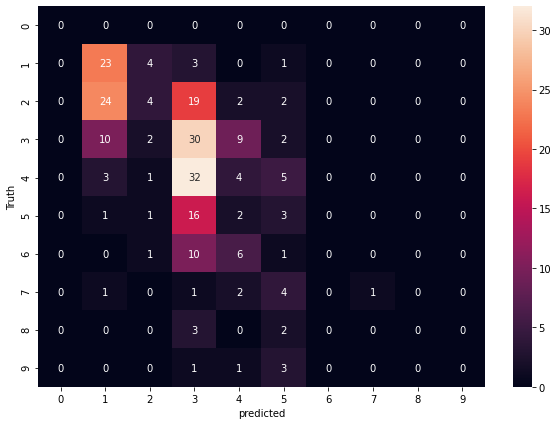

In [117]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

Average F-Score is 0.21 which is lower than Random Forest and Logistic Regression models. As listed below, the SVM model does not give satidfactory F-Score for categories higher than 6.

In [118]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           1       0.37      0.74      0.49        31
           2       0.31      0.08      0.12        51
           3       0.26      0.57      0.36        53
           4       0.15      0.09      0.11        45
           5       0.13      0.13      0.13        23
           6       0.00      0.00      0.00        18
           7       1.00      0.11      0.20         9
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5

    accuracy                           0.27       240
   macro avg       0.25      0.19      0.16       240
weighted avg       0.25      0.27      0.21       240



The following line of code estimates the category of movies in the scoring dataset.

In [119]:
y_score_SVM = pd.DataFrame(model_SVM.predict(X_score))
y_score_SVM

,0
0,3
1,7
2,5
3,5
4,5
...,...
86,1
87,1
88,1
89,1


## 5. Neural Network - Regression Model

The accuracy and F-Score of the previous ML models are not satisfactory. Therefore, we decided to try Neural Network (NN) models and check their performance. In the first NN model, we estimate the "total" revenue and then assign the corresponding category. To do so, we normalized the continuous values by log(total) / log (2784) where 2784 is the maximum total revenue in the Training spreadsheet.

The following function ("category") returns the class of each attribute based on the normalized total revenue as the input.

In [120]:
def category(ii):
    
    if ii > np.log(750)/np.log(2784):
        cat = 9
    elif ii > np.log(450)/np.log(2784) and ii <= np.log(750)/np.log(2784):
        cat = 8
    elif ii > np.log(275)/np.log(2784) and ii <= np.log(450)/np.log(2784):
        cat = 7
    elif ii > np.log(175)/np.log(2784) and ii <= np.log(275)/np.log(2784):
        cat = 6
    elif ii > np.log(100)/np.log(2784) and ii <= np.log(175)/np.log(2784):
        cat = 5
    elif ii > np.log(50)/np.log(2784) and ii <= np.log(100)/np.log(2784):
        cat = 4
    elif ii > np.log(20)/np.log(2784) and ii <= np.log(50)/np.log(2784):
        cat = 3
    elif ii > np.log(5)/np.log(2784) and ii <= np.log(20)/np.log(2784):
        cat = 2
    elif ii <= np.log(5)/np.log(2784):
        cat = 1
    return cat

We pick the first 32 features by using the Feature_Importance method.

In [121]:
X_train, X_test, y_train, y_test, X_score = \
Feature_Importance (df2_regression, 'total', n_features = 32, test_size = 0.2)

    importance                                     feature
23    0.053405                  source_Original Screenplay
1     0.048733          creative_type_Contemporary Fiction
12    0.047923    source_Based on Fiction Book/Short Story
66    0.046013       movie_board_rating_display_name_PG-13
67    0.043573           movie_board_rating_display_name_R
0     0.036533                                movie_sequel
65    0.036304          movie_board_rating_display_name_PG
35    0.035915                                genre_Comedy
5     0.034653            creative_type_Historical Fiction
32    0.032999                                genre_Action
4     0.029548                       creative_type_Fantasy
38    0.028945                                 genre_Drama
43    0.028507                     genre_Thriller/Suspense
8     0.028285               creative_type_Science Fiction
24    0.023113                               source_Remake
71    0.020710  movie_release_pattern_display_name_Limit

In [122]:
X_score.shape

(91, 32)

In [123]:
X_test.shape

(240, 32)

The function ("rmse") calculates root-mean-square between the predicted and actual values of y.

In [124]:
from tensorflow.keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [125]:
NN_reg = keras.Sequential([
    
    keras.layers.Dense(20, input_shape = (32, ), activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1),  
])

NN_reg.compile(optimizer = 'adam',
                loss = rmse,
                metrics = [rmse])


#kernel_regularizer = regularizers.l2(2)
#tf.keras.optimizers.Adam(learning_rate=0.001)
    
history_reg = NN_reg.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 200, batch_size = 32)

Epoch 1/200
30/30 [==============================] - 1s 14ms/step - loss: 0.6259 - rmse: 0.6251 - val_loss: 0.3040 - val_rmse: 0.2996
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.4296 - rmse: 0.4295 - val_loss: 0.2823 - val_rmse: 0.2790
Epoch 3/200
30/30 [==============================] - 0s 5ms/step - loss: 0.3608 - rmse: 0.3605 - val_loss: 0.2475 - val_rmse: 0.2451
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.3205 - rmse: 0.3205 - val_loss: 0.2382 - val_rmse: 0.2363
Epoch 5/200
30/30 [==============================] - 0s 5ms/step - loss: 0.2963 - rmse: 0.2960 - val_loss: 0.2241 - val_rmse: 0.2224
Epoch 6/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2767 - rmse: 0.2767 - val_loss: 0.2133 - val_rmse: 0.2117
Epoch 7/200
30/30 [==============================] - 0s 6ms/step - loss: 0.2589 - rmse: 0.2590 - val_loss: 0.1997 - val_rmse: 0.1984
Epoch 8/200
30/30 [==============================] - 0s 5ms/step - l

30/30 [==============================] - 0s 4ms/step - loss: 0.1581 - rmse: 0.1580 - val_loss: 0.1436 - val_rmse: 0.1428
Epoch 124/200
30/30 [==============================] - 0s 4ms/step - loss: 0.1555 - rmse: 0.1555 - val_loss: 0.1433 - val_rmse: 0.1425
Epoch 125/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1585 - rmse: 0.1584 - val_loss: 0.1438 - val_rmse: 0.1430
Epoch 126/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1565 - rmse: 0.1565 - val_loss: 0.1451 - val_rmse: 0.1444
Epoch 127/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1570 - rmse: 0.1570 - val_loss: 0.1452 - val_rmse: 0.1445
Epoch 128/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1573 - rmse: 0.1574 - val_loss: 0.1442 - val_rmse: 0.1435
Epoch 129/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1595 - rmse: 0.1595 - val_loss: 0.1443 - val_rmse: 0.1435
Epoch 130/200
30/30 [==============================] - 0s 5ms/step - 

Epoch 184/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1495 - rmse: 0.1495 - val_loss: 0.1453 - val_rmse: 0.1443
Epoch 185/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1537 - rmse: 0.1535 - val_loss: 0.1449 - val_rmse: 0.1439
Epoch 186/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1515 - rmse: 0.1516 - val_loss: 0.1450 - val_rmse: 0.1440
Epoch 187/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1513 - rmse: 0.1513 - val_loss: 0.1443 - val_rmse: 0.1431
Epoch 188/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1537 - rmse: 0.1537 - val_loss: 0.1445 - val_rmse: 0.1436
Epoch 189/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1507 - rmse: 0.1508 - val_loss: 0.1451 - val_rmse: 0.1438
Epoch 190/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1518 - rmse: 0.1517 - val_loss: 0.1450 - val_rmse: 0.1439
Epoch 191/200
30/30 [==============================] - 

As shown below, this model has three layers with total of 881 weight and bias parameters that should be optimized.

In [126]:
NN_reg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                660       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


The following figure shows the loss of training and validation datasets with respect to epochs. In this case, validation dataset is the same as test dataset.

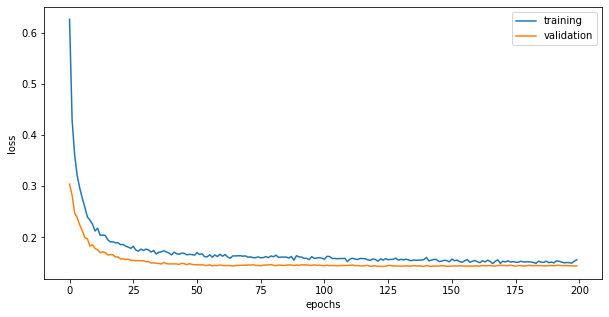

In [127]:
plt.figure(figsize = (10, 5))
plt.plot(history_reg.history['loss'], label = 'training')
plt.plot(history_reg.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

The following figure shows the normalized value of actual y with respect to predicted y for the training dataset.

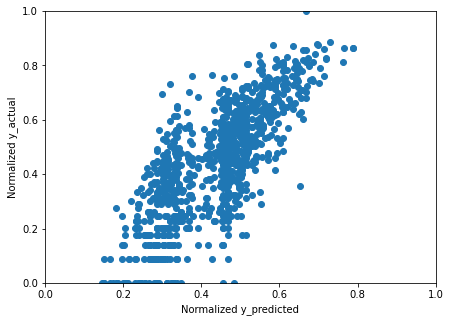

In [128]:
plt.figure(figsize = (7,5))
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Normalized y_predicted')
plt.ylabel('Normalized y_actual')
y_predicted_2 = NN_reg.predict(X_train)
plt.scatter(y_predicted_2, y_train)

The following figure shows the normalized value of actual y with respect to predicted y for the training dataset.

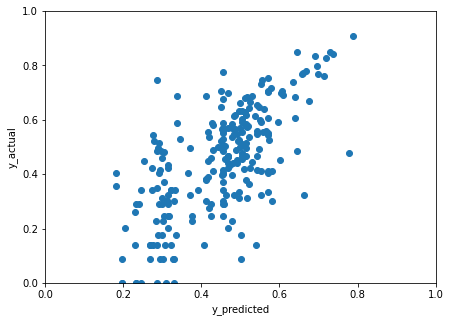

In [129]:
plt.figure(figsize = (7,5))
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('y_predicted')
plt.ylabel('y_actual')
y_predicted = NN_reg.predict(X_test)
plt.scatter(y_predicted, y_test)

In [130]:
y_predicted = [category(ii) for ii in list(y_predicted)]
y_test = [category(ii) for ii in list(y_test)]

The accuracy of the NN model on test dataset is 0.29 which is comparable to the accuracy of Random Forest models. It is important to mention that even this NN could not achieve a satisfactory accuracy! 

In [131]:
counter = 0
for ii in range(len(y_test)):
    if y_test[ii] == y_predicted[ii]:
        counter += 1

        accuracy = counter / len(y_test)
print ('Test accuracy= ', accuracy)

Test accuracy=  0.31666666666666665


Text(69.0, 0.5, 'Truth')

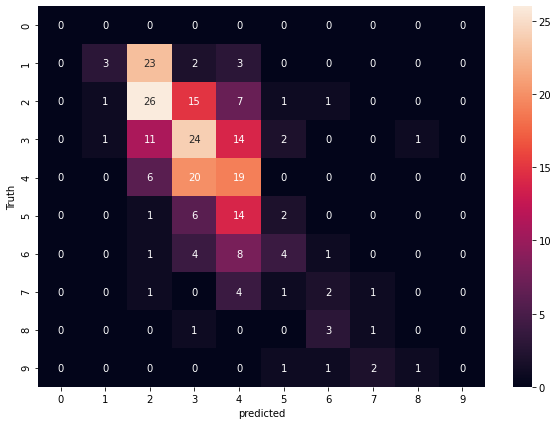

In [132]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F-Score for this NN model is 0.28 which is NOT still satisfactory!

In [133]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           1       0.60      0.10      0.17        31
           2       0.38      0.51      0.43        51
           3       0.33      0.45      0.38        53
           4       0.28      0.42      0.33        45
           5       0.18      0.09      0.12        23
           6       0.12      0.06      0.08        18
           7       0.25      0.11      0.15         9
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5

    accuracy                           0.32       240
   macro avg       0.24      0.19      0.19       240
weighted avg       0.32      0.32      0.28       240



The following line of code estimates the category of movies in the scoring dataset.

In [134]:
y_score_NN_reg = NN_reg.predict(X_score)
y_score_NN_reg = [category(ii) for ii in list(y_score_NN_reg)]
y_score_NN_reg = pd.DataFrame(y_score_NN_reg)
y_score_NN_reg

,0
0,4
1,5
2,5
3,7
4,8
...,...
86,2
87,2
88,2
89,2


## 6. Neural Network - Classification Model

In the second NN model, we directly estimate the class of each attribute by using the "sigmoid" activation function in the last layer.

In [135]:
X_train, X_test, y_train, y_test, X_score = \
Feature_Importance (df2_classification, 'Category', n_features = 32, test_size = 0.2)

    importance                                     feature
74    0.055732     movie_release_pattern_display_name_Wide
0     0.050396                                movie_sequel
23    0.046239                  source_Original Screenplay
12    0.044262    source_Based on Fiction Book/Short Story
71    0.040043  movie_release_pattern_display_name_Limited
67    0.039006           movie_board_rating_display_name_R
66    0.037381       movie_board_rating_display_name_PG-13
1     0.035366          creative_type_Contemporary Fiction
35    0.032189                                genre_Comedy
38    0.030880                                 genre_Drama
4     0.029025                       creative_type_Fantasy
32    0.028701                                genre_Action
43    0.028015                     genre_Thriller/Suspense
5     0.027941            creative_type_Historical Fiction
8     0.027838               creative_type_Science Fiction
65    0.027331          movie_board_rating_display_name_

In [136]:
X_score.shape

(91, 32)

In [137]:
X_test.shape

(240, 32)

In [138]:
NN_class = keras.Sequential([
    
    keras.layers.Dense(32, input_shape = (32, ), activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = 'sigmoid'), 
])

NN_class.compile(optimizer = 'SGD',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])


#kernel_regularizer = regularizers.l2(2)
#tf.keras.optimizers.Adam(learning_rate=0.001)
    
history_class = NN_class.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 500, batch_size = 32)

Epoch 1/500
30/30 [==============================] - 1s 12ms/step - loss: 2.3778 - accuracy: 0.1297 - val_loss: 2.2154 - val_accuracy: 0.2167
Epoch 2/500
30/30 [==============================] - 0s 6ms/step - loss: 2.2975 - accuracy: 0.1496 - val_loss: 2.1931 - val_accuracy: 0.2167
Epoch 3/500
30/30 [==============================] - 0s 7ms/step - loss: 2.2612 - accuracy: 0.1715 - val_loss: 2.1761 - val_accuracy: 0.2125
Epoch 4/500
30/30 [==============================] - 0s 5ms/step - loss: 2.2416 - accuracy: 0.1768 - val_loss: 2.1632 - val_accuracy: 0.2208
Epoch 5/500
30/30 [==============================] - 0s 5ms/step - loss: 2.2152 - accuracy: 0.1789 - val_loss: 2.1483 - val_accuracy: 0.2292
Epoch 6/500
30/30 [==============================] - 0s 5ms/step - loss: 2.1990 - accuracy: 0.1946 - val_loss: 2.1335 - val_accuracy: 0.2458
Epoch 7/500
30/30 [==============================] - 0s 5ms/step - loss: 2.1658 - accuracy: 0.1904 - val_loss: 2.1183 - val_accuracy: 0.2458
Epoch 8/500


Epoch 59/500
30/30 [==============================] - 0s 7ms/step - loss: 1.9435 - accuracy: 0.2395 - val_loss: 1.8774 - val_accuracy: 0.2583
Epoch 60/500
30/30 [==============================] - 0s 9ms/step - loss: 1.9485 - accuracy: 0.2280 - val_loss: 1.8738 - val_accuracy: 0.2583
Epoch 61/500
30/30 [==============================] - 0s 8ms/step - loss: 1.9404 - accuracy: 0.2385 - val_loss: 1.8714 - val_accuracy: 0.2708
Epoch 62/500
30/30 [==============================] - 0s 10ms/step - loss: 1.9440 - accuracy: 0.2165 - val_loss: 1.8661 - val_accuracy: 0.2833
Epoch 63/500
30/30 [==============================] - 0s 15ms/step - loss: 1.9534 - accuracy: 0.2291 - val_loss: 1.8641 - val_accuracy: 0.2625
Epoch 64/500
30/30 [==============================] - 0s 9ms/step - loss: 1.9451 - accuracy: 0.2270 - val_loss: 1.8621 - val_accuracy: 0.2750
Epoch 65/500
30/30 [==============================] - 0s 9ms/step - loss: 1.9598 - accuracy: 0.2374 - val_loss: 1.8619 - val_accuracy: 0.2875
Epoc

30/30 [==============================] - 0s 5ms/step - loss: 1.8474 - accuracy: 0.2563 - val_loss: 1.7571 - val_accuracy: 0.2708
Epoch 174/500
30/30 [==============================] - 0s 5ms/step - loss: 1.8469 - accuracy: 0.2280 - val_loss: 1.7572 - val_accuracy: 0.2500
Epoch 175/500
30/30 [==============================] - 0s 5ms/step - loss: 1.8400 - accuracy: 0.2542 - val_loss: 1.7567 - val_accuracy: 0.2708
Epoch 176/500
30/30 [==============================] - 0s 5ms/step - loss: 1.8365 - accuracy: 0.2521 - val_loss: 1.7545 - val_accuracy: 0.2583
Epoch 177/500
30/30 [==============================] - 0s 5ms/step - loss: 1.8407 - accuracy: 0.2542 - val_loss: 1.7541 - val_accuracy: 0.2583
Epoch 178/500
30/30 [==============================] - 0s 5ms/step - loss: 1.8362 - accuracy: 0.2636 - val_loss: 1.7550 - val_accuracy: 0.2458
Epoch 179/500
30/30 [==============================] - 0s 5ms/step - loss: 1.8445 - accuracy: 0.2458 - val_loss: 1.7541 - val_accuracy: 0.2417
Epoch 180/500

30/30 [==============================] - 0s 9ms/step - loss: 1.7938 - accuracy: 0.2793 - val_loss: 1.7191 - val_accuracy: 0.2917
Epoch 288/500
30/30 [==============================] - 0s 8ms/step - loss: 1.7929 - accuracy: 0.2751 - val_loss: 1.7157 - val_accuracy: 0.2792
Epoch 289/500
30/30 [==============================] - 0s 5ms/step - loss: 1.8094 - accuracy: 0.2626 - val_loss: 1.7164 - val_accuracy: 0.3000
Epoch 290/500
30/30 [==============================] - 0s 5ms/step - loss: 1.7795 - accuracy: 0.2626 - val_loss: 1.7155 - val_accuracy: 0.2792
Epoch 291/500
30/30 [==============================] - 0s 5ms/step - loss: 1.7841 - accuracy: 0.2646 - val_loss: 1.7154 - val_accuracy: 0.2917
Epoch 292/500
30/30 [==============================] - 0s 5ms/step - loss: 1.8017 - accuracy: 0.2741 - val_loss: 1.7168 - val_accuracy: 0.2958
Epoch 293/500
30/30 [==============================] - 0s 4ms/step - loss: 1.8105 - accuracy: 0.2594 - val_loss: 1.7167 - val_accuracy: 0.2958
Epoch 294/500

30/30 [==============================] - 0s 5ms/step - loss: 1.7517 - accuracy: 0.2762 - val_loss: 1.6877 - val_accuracy: 0.3042
Epoch 402/500
30/30 [==============================] - 0s 5ms/step - loss: 1.7695 - accuracy: 0.2646 - val_loss: 1.6880 - val_accuracy: 0.2917
Epoch 403/500
30/30 [==============================] - 0s 4ms/step - loss: 1.7765 - accuracy: 0.2646 - val_loss: 1.6883 - val_accuracy: 0.2917
Epoch 404/500
30/30 [==============================] - 0s 4ms/step - loss: 1.7762 - accuracy: 0.2720 - val_loss: 1.6890 - val_accuracy: 0.2917
Epoch 405/500
30/30 [==============================] - 0s 5ms/step - loss: 1.7862 - accuracy: 0.2605 - val_loss: 1.6912 - val_accuracy: 0.2875
Epoch 406/500
30/30 [==============================] - 0s 5ms/step - loss: 1.7506 - accuracy: 0.2814 - val_loss: 1.6906 - val_accuracy: 0.2917
Epoch 407/500
30/30 [==============================] - 0s 5ms/step - loss: 1.7717 - accuracy: 0.2490 - val_loss: 1.6899 - val_accuracy: 0.2750
Epoch 408/500

This NN model has 1754 parameters that should be optimized by backpropagation.

In [139]:
NN_class.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                170       
                                                                 
Total params: 1,754
Trainable params: 1,754
Non-trainable params: 0
_________________________________________________________________


The following figures show the profiles of "loss" and "accuracy" with respect to epochs for the training and validation (test) datasets.

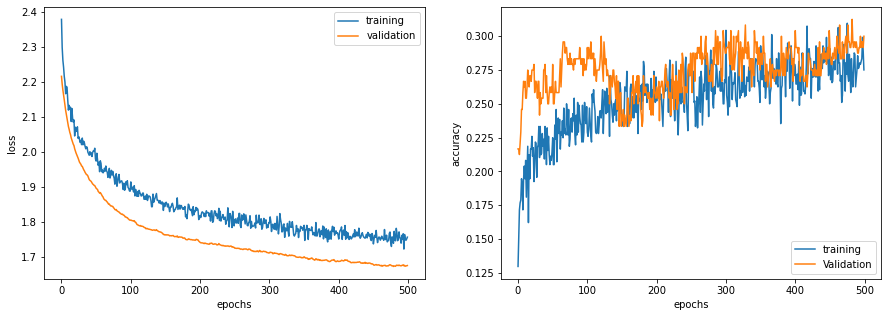

In [140]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot(history_class.history['loss'], label = 'training')
plt.plot(history_class.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_class.history['accuracy'], label = 'training')
plt.plot(history_class.history['val_accuracy'], label = 'Validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


The accuracy of the NN model on test set is around 0.3.

In [141]:
NN_class.evaluate(X_test, y_test)

8/8 [==============================] - 0s 2ms/step - loss: 1.6761 - accuracy: 0.3000


[1.676098108291626, 0.30000001192092896]

In [142]:
y_predicted = NN_class.predict(X_test)

In [143]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
y_predicted_labels = np.array(y_predicted_labels)

This NN model does not have high performance in predicting the class of categories higher than 6.

Text(69.0, 0.5, 'Truth')

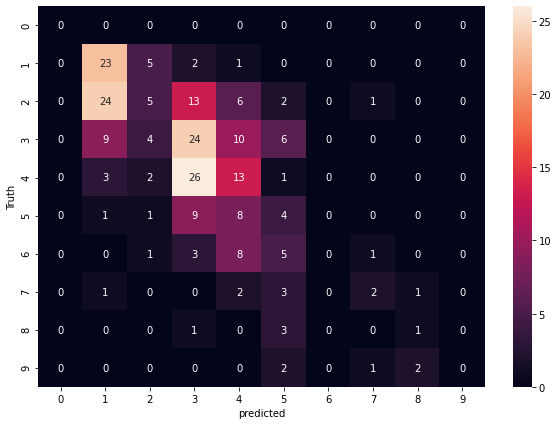

In [144]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted_labels)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

And finally F-Score = 0.25 which is very close to the F-Score of the previous model.

In [145]:
print(classification_report(y_test, y_predicted_labels, zero_division = False))

              precision    recall  f1-score   support

           1       0.38      0.74      0.50        31
           2       0.28      0.10      0.14        51
           3       0.31      0.45      0.37        53
           4       0.27      0.29      0.28        45
           5       0.15      0.17      0.16        23
           6       0.00      0.00      0.00        18
           7       0.40      0.22      0.29         9
           8       0.25      0.20      0.22         5
           9       0.00      0.00      0.00         5

    accuracy                           0.30       240
   macro avg       0.23      0.24      0.22       240
weighted avg       0.26      0.30      0.26       240



The following line of code estimates the category of movies in the scoring dataset.

In [146]:
y_score_NN_class = NN_class.predict(X_score)
y_score_NN_class = [np.argmax(i) for i in y_score_NN_class]
y_score_NN_class = pd.DataFrame(y_score_NN_class)
y_score_NN_class

,0
0,5
1,7
2,7
3,5
4,8
...,...
86,1
87,1
88,1
89,1


## Learning curve - High Bias and/or High Variance Problem
### Random Forest model (factorization)
In this subsection, we want to evaluate the learning curve of the ML model with the highest accuracy, which is Random Forest with Factorization. The interpretation of this curve will help us to understand why the accuracy of our model is not satisfactory. Do we have high bias or high variance or both of them?

In [148]:
# Assign all data to training set
X_train, X_test, y_train, y_test, X_score = factorization(df_classification, 'Category', test_size = 0.01)

In [149]:
def plot_learning_curve(train_scores, test_scores, train_sizes, fig_name, title, xlabel, ylabel):
    train_mean = 1 - np.mean(train_scores, axis=1)

    test_mean = 1 - np.mean(test_scores, axis = 1)

    plt.plot(train_sizes, train_mean, '--',  label="Training score")
    plt.plot(train_sizes, test_mean, label="Cross-validation score")

    plt.title(title)
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel) 
    plt.legend(loc="best")
    plt.savefig(fig_name, bbox_inches='tight')

In [150]:
train_sizes, train_scores, test_scores = learning_curve \
(RandomForestClassifier(max_depth=15, max_leaf_nodes=100, n_estimators=50), \
 X_train, y_train, cv = 5, scoring='accuracy', train_sizes=np.linspace(0.01, 1.0, 50))

### Important Conclusions
#### High bias
As shown in the learning curve below, the training error is very high, suggesting that there is a high bias problem. To solve this problem, we need to add more features to the training data or use more complicated models such as neural networks with high number of layers and neurons. Analyzing the "board_rating_reason" and adding more features related to the words in this column may improve the accuracy of the training dataset. It is very important to mention that adding more features to the ML model may lead to overfitting if we do not have enough data for learning algorithm!
#### High variance 
As shown below, there is a big difference between the cross-validation error and training error, suggesting that we have high-variance problem due to overfitting of the model on training data. One way to solve this problem is to use L2-regularization or dropout techniques. However, the practical way to solve this problem is to collect more training data, especially for classes with Category higher than 6. As discussed before, the ML models do not have high performance for predicting the class of categories higher than 6. One reason to explain this issue is the low number of training data corresponding to these classes. As shown in the bar chart below, the number of training examples for 6 to 9 classes is significantly lower than the number of training data for 1 to 5 classes.

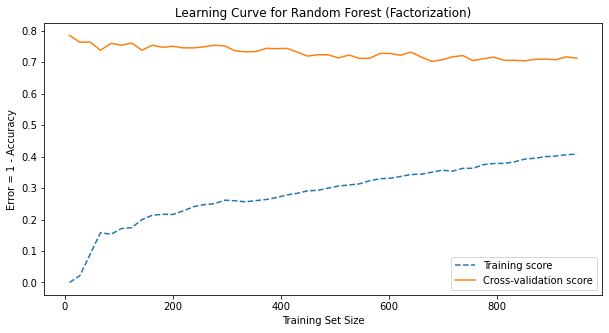

In [151]:
plt.figure(figsize=(10,5))
plot_learning_curve(train_scores,test_scores,train_sizes,"Random_Forest_Curve.png",
           "Learning Curve for Random Forest (Factorization)","Training Set Size","Error = 1 - Accuracy")

<BarContainer object of 9 artists>

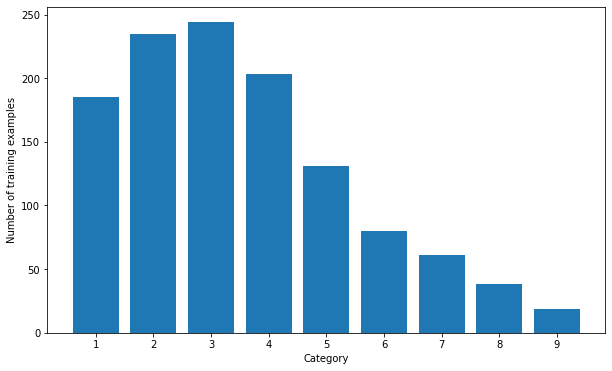

In [152]:
Categories = list(range(1,10))
Count = []

for ii in range (len(Categories)):
        sum1 = sum(df['Category'] == Categories[ii])
        Count.append(sum1)
plt.figure(figsize=(10,6))
plt.xlabel('Category')
plt.ylabel('Number of training examples')
ypos = np.arange(len(Categories))
plt.xticks(ypos, Categories)
plt.bar(ypos, Count)

## Prediction of Scoring Data

We choose Model 2 - Random Forest (One-Hot-Coding) and Model 3 - Random Forest (Factorization) becuase their performance for predicting the category of classes higher than 6 is relatively higher than other ML models in this notebook.

In [153]:
ML_outputs = pd.DataFrame()
ML_outputs['id'] = score_1['id'].copy()

In [154]:
ML_outputs['Random_Forest_Category'] = y_score_RF_cat.copy()

In [155]:
ML_outputs['Random_Forest_Hot'] = y_score_RF_hot.copy()

In [156]:
ML_outputs.shape

(91, 3)

In [157]:
ML_outputs.to_csv('Scoring_ML_Outputs.csv')

There are 65 out of 91 same predictions between Random_Forest_Category and Random_Forest_Hot, which is around 71% similarity.

In [158]:
sum(ML_outputs['Random_Forest_Category'] == ML_outputs['Random_Forest_Hot'])

65

In [160]:
ML_outputs.head(30)

,id,Random_Forest_Category,Random_Forest_Hot
0,7970115,6,5
1,174540115,9,8
2,149080115,8,8
3,136020115,8,8
4,53500115,9,9
5,109880115,9,9
6,168300115,8,5
7,72600115,9,8
8,154940115,8,5
9,149170115,9,9
